In [ ]:
!pip install av

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
from torch import nn
from torch import optim
import os
import numpy as np
import pandas as pd
from torchvision.io import read_video
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import time
import copy

In [ ]:
# define transformation
#transformation = transforms.Compose([
#                    transforms.ToTensor(),
#                    transforms.Resize(64)
#])
#이 방법쓰면 바로
preprocess_new_ver = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.Resize((244,244)),
    #transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
#annotation_file : 정답 라벨링 되어 있는 csv파일
#video_data.csv
#video_dir = 이미지 들어간 폴더.
#out_folder/mixed
class MyOwnDataset(Dataset):
    def __init__(self, annotations_file, video_dir, transform=None, target_transform=None):
        self.video_labels=pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.video_dir = video_dir
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.video_labels)
    def __getitem__(self, idx):
        video_path = os.path.join(self.video_dir, self.video_labels.iloc[idx,0])
        #video = read_video(video_path)
        #video = EncodedVideo.from_path(video_path)
        #video_data=video.get_clip(start_sec = 0, end_sec = (num_frames * sampling_rate)/frames_per_second)
        video,_,_ = read_video(video_path, start_pts=0, end_pts=29)#30개의 프레임 사용
        video = video.permute(0,3,1,2)
        label = self.video_labels.iloc[idx,1]
        if(self.transform):
          #video_data = self.transform(video_data)
          video_data_list = []
          for i in video:
            video_data_list.append(self.transform(i))
          video_data = torch.stack(video_data_list, dim=0)
        #if(self.target_transform):#라벨 부분 변경해주는거
        #  label = self.target_transform(label)
        if(label == 0):
          #label = torch.FloatTensor([1.0, 0.0])
          label=torch.Tensor([0.0]).type(torch.LongTensor)
        else:
          #label = torch.FloatTensor([0.0, 1.0])
          label=torch.Tensor([1.0]).type(torch.LongTensor)
        #sample = {'video':video, 'label': label}
        #return sample
        return video_data, label
    def use_pandas_before(self, pandas_dataframe):
        self.video_labels = pandas_dataframe

In [ ]:
cur_path = os.getcwd()
cur_path+='/drive/Shareddrives/capstone_data_process/temp'

In [ ]:
#데이터 읽을 떄 경로 지정해 줘야함.
all_data = pd.read_csv((cur_path+'/celeb-df_v2/video_data.csv'), names=['file_name', 'label'])

In [ ]:
real_num = len(all_data[all_data['label'] == 1])
fake_num = len(all_data[all_data['label'] == 0])
print(real_num, fake_num , real_num+fake_num)
#갯수로만 보면 566/5349*100 = 10.5

566 5349 5915


In [ ]:
real_alls = all_data[all_data['label'] == 1]
fake_sample = all_data[all_data['label'] == 0].sample(frac=0.11)

In [ ]:
len(fake_sample)

588

In [ ]:
print(type(real_alls), type(fake_sample))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [ ]:
all_data_subset = pd.concat([real_alls, fake_sample])
display(all_data_subset)

,file_name,label
0,id0_0000.avi,1
1,id0_0001.avi,1
2,id0_0002.avi,1
3,id0_0003.avi,1
4,id0_0004.avi,1
...,...,...
1317,id41_id47_0003.avi,0
2732,id28_id0_0006.avi,0
2039,id24_id21_0005.avi,0
2137,id21_id25_0002.avi,0


In [ ]:
#훈련 데이터셋 data_train       0.6
#검증 데이터셧 data_validation  0.2
#테스트 데이터셋 data_test      0.2
########################################
#data_train, data_test = train_test_split(all_data, test_size = 0.2, random_state=2022)
#data_train, data_validation = train_test_split(data_train, test_size=0.25, random_state=2022)
data_train, data_test = train_test_split(all_data_subset, test_size = 0.2, random_state=2022)
data_train, data_validation = train_test_split(data_train, test_size=0.25, random_state=2022)

In [ ]:
print(len(data_train), len(data_validation), len(data_test))

692 231 231


In [ ]:
#경로는 사용할때 조정해줘야함
train_data = MyOwnDataset((cur_path+'/celeb-df_v2/video_data.csv'), (cur_path+'/celeb-df_v2/pre_process/mixed'), preprocess_new_ver)
validation_data = MyOwnDataset((cur_path+'/celeb-df_v2/video_data.csv'), (cur_path+'/celeb-df_v2/pre_process/mixed'), preprocess_new_ver)
test_data = MyOwnDataset((cur_path+'/celeb-df_v2/video_data.csv'), (cur_path+'/celeb-df_v2/pre_process/mixed'), preprocess_new_ver)

In [ ]:
train_data.use_pandas_before(data_train)
validation_data.use_pandas_before(data_validation)
test_data.use_pandas_before(data_test)
print(len(train_data), len(validation_data), len(test_data))

692 231 231


In [ ]:
train_dataloader = DataLoader(train_data, batch_size=2, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=2, shuffle=True)
#train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)
#validation_dataloader = DataLoader(validation_data, batch_size=4, shuffle=True)
#test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True)

In [ ]:
#is_fake = 0
#is_real = 0
#for first, second in validation_dataloader:
#  #print(second)
#  for i in second.view(-1):
#    if(i ==0):
#      is_fake +=1
#    else:
#      is_real += 1
#print(is_fake, is_real)

In [ ]:
cur_path

'/content/drive/Shareddrives/capstone_data_process/temp'

In [ ]:
class Model2(nn.Module):
    def __init__(self, num_classes=2,latent_dim= 1664, lstm_layers=1 , hidden_dim = 1664, bidirectional = False):
        super(Model2, self).__init__()
        #model = models.mobilenet_v2(pretrained=True)
        model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet169', pretrained=True)
        self.model = nn.Sequential(*list(model.children())[:-1])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.dp = nn.Dropout(0.5)
        self.linear1 = nn.Linear(hidden_dim,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        #print('@',x.shape)
        x = x.view(batch_size,seq_length,-1)
        #print('@@',x.shape)
        x_lstm,_ = self.lstm(x,None)
        sp_frame_index = torch.argmax(torch.mean(x,dim=(0,2)))
        #print('@@@',x.shape)
        return sp_frame_index, fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [ ]:
device = 'cuda'
model = Model2().to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
device = 'cuda'
model = model.to(device)
#model.load_state_dict(torch.load(cur_path+'/trained_models/sgd_model_version5_lr_1e-07_val_0.262584_acc_74.03_f1_0.73_state_dict_sig.pt'))
loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}
best_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
#start_time = time.time()

In [ ]:
#여기서부터 학습 한번 진행시켜보자....
loss_function = nn.CrossEntropyLoss().cuda()#이것도 .cuda()붙여줘야하나
#loss_function = nn.BCELoss().cuda()
opt = optim.Adam(model.parameters(), lr=0.0001)
#opt = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5, min_lr =0.0000001)

In [ ]:
epoch = 100
print(cur_path)
trained_model_path = cur_path+'/trained_models'
print(trained_model_path)

/content/drive/Shareddrives/capstone_data_process/temp
/content/drive/Shareddrives/capstone_data_process/temp/trained_models


In [ ]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [ ]:
#원본/예측
deepfake_deepfake = 0
deepfake_normal = 0
normal_deepfake = 0
normal_normal = 0

In [ ]:
len(validation_dataloader.dataset)

231

function ClickConnect(){
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect, 60 * 1000)

In [ ]:
#best_loss = 0.262584

In [ ]:
import shutil

In [ ]:
#print_confusion_matrix(torch.argmax(torch.argmax(pred, dim = 1)), b.view(-1))
#confusion_matrix(b.view(-1).numpy(), torch.argmax(pred, dim = 1).cpu().numpy())

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sn
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print(cm[0][0], cm[0][1],cm[1][0],cm[1][1])
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    f1_report = metrics.classification_report(y_true,y_pred)
    print("Calculated Accuracy",calculated_acc*100,"f1-score",f1_report)

In [ ]:
start_time = time.time()
for index in range(epoch):
  total_numbers = 0
  deepfake_deepfake = 0
  deepfake_normal = 0
  normal_deepfake = 0
  normal_normal = 0
  current_lr = get_lr(opt)
  print('Epoch {}/{}, current lr= {}'.format(index, epoch-1, current_lr))
  #model train phase
  model.train()
  train_dataloader_length = len(train_dataloader.dataset)
  epoch_train_loss = 0.0
  for data, label in train_dataloader:
    data = data.to(device)
    label = label.to(device)
    _, _, pred = model(data)
    loss_value = loss_function(pred, label.view(-1))
    epoch_train_loss += loss_value.item()
    opt.zero_grad()
    loss_value.backward()
    opt.step()
  epoch_train_loss /= train_dataloader_length
  loss_history['train'].append(epoch_train_loss)
  #model evaluation with validation set phase
  model.eval()
  with torch.no_grad():
    validation_dataloader_length = len(validation_dataloader.dataset)
    epoch_validation_loss = 0.0
    total_preds = np.array([])
    total_labels = np.array([])
    for data, label in validation_dataloader:
      data = data.to(device)
      label = label.to(device)
      #pred, sp_frame = model(data)
      _, _,pred = model(data)
      total_preds = np.append(total_preds, torch.argmax(pred, dim = 1).cpu().numpy())
      total_labels = np.append(total_labels, label.view(-1).cpu().numpy())
      loss_value = loss_function(pred, label.view(-1))
      epoch_validation_loss += loss_value.item()
    print_confusion_matrix(total_labels, total_preds)
  epoch_validation_loss /= validation_dataloader_length
  loss_history['val'].append(epoch_validation_loss)

  if(epoch_validation_loss < best_loss):
    best_loss = epoch_validation_loss
    best_model_wts = copy.deepcopy(model.state_dict())
    torch.save(model.state_dict(), trained_model_path+'/flatten_adam_model_state_dict_sig.pt')
    shutil.copy(trained_model_path+'/flatten_adam_model_state_dict_sig.pt', trained_model_path+'/flatten_adam_model_state_dict_sig_spare.pt')
    print('Update Model with best Validation Result')

  lr_scheduler.step(epoch_validation_loss)
  if(current_lr != get_lr(opt)):
    print('Loading best model weights!')
    model.load_state_dict(best_model_wts)
  
  print('train loss: %.6f, val loss: %.6f, time: %.4f min' %(epoch_train_loss, epoch_validation_loss, (time.time()-start_time)/60))
  print('-'*100)
model.load_state_dict(best_model_wts)

Epoch 0/99, current lr= 0.0001
75 42 36 78
Calculated Accuracy 66.23376623376623 f1-score               precision    recall  f1-score   support

         0.0       0.68      0.64      0.66       117
         1.0       0.65      0.68      0.67       114

    accuracy                           0.66       231
   macro avg       0.66      0.66      0.66       231
weighted avg       0.66      0.66      0.66       231

Update Model with best Validation Result
train loss: 0.359494, val loss: 0.319259, time: 16.9185 min
----------------------------------------------------------------------------------------------------
Epoch 1/99, current lr= 0.0001
95 22 66 48
Calculated Accuracy 61.904761904761905 f1-score               precision    recall  f1-score   support

         0.0       0.59      0.81      0.68       117
         1.0       0.69      0.42      0.52       114

    accuracy                           0.62       231
   macro avg       0.64      0.62      0.60       231
weighted avg      

<All keys matched successfully>

In [ ]:
torch.save(model, trained_model_path+'/flatten_new_adam_model_last_choice.pt')
torch.save(model.state_dict(), trained_model_path+'/flatten_adam_model_last_choice_state_dict_sig.pt')
torch.save({'model':model.state_dict(), 'optimizer':opt.state_dict()}, trained_model_path+'/flatten_adam_model_sig_last_choice_all.tar')

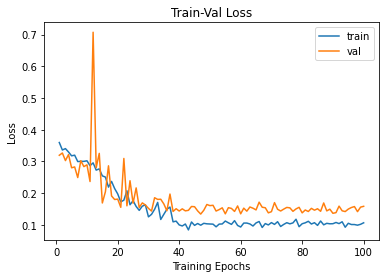

In [ ]:
import matplotlib.pyplot as plt
# Train-Validation progress
num_epochs = 100

# plot loss progress
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_history['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_history['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
#plt.title('Train-Val Accuracy')
#plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
#plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
#plt.ylabel('Accuracy')
#plt.xlabel('Training Epochs')
#plt.legend()
#plt.show()

In [ ]:
#print(sp_frame)

In [ ]:
epoch_validation_loss

0.1581436772435804

In [ ]:
best_loss

0.13367438706481433